In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from catboost import CatBoostClassifier
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import wandb
from wandb.lightgbm import wandb_callback

pd.set_option("display.max_columns", 181)
pd.set_option("display.min_rows", 200)

In [50]:
data_dictionary = pd.read_csv("DataDictionaryWiDS2021.csv")
unlabeled = pd.read_csv("UnlabeledWiDS2021.csv")
training = pd.read_csv("TrainingWiDS2021.csv")

In [51]:
column_datatype_mapping = dict(zip(data_dictionary['Variable Name'], data_dictionary['Data Type']))

del training['Unnamed: 0']
del unlabeled['Unnamed: 0']

In [52]:
all_data = training.append(unlabeled).drop(['encounter_id', 
                                            'hospital_id', 
                                            'diabetes_mellitus'], axis=1)

all_data.shape

(140391, 177)

In [53]:
cat_cols = ['ethnicity', 'gender', 'hospital_admit_source',
           'icu_admit_source', 'icu_stay_type', 'icu_type',
           'apache_2_diagnosis', 'apache_3j_diagnosis','icu_id']


binary_cols = data_dictionary.loc[data_dictionary['Data Type'] == 'binary','Variable Name'].values
num_cols = data_dictionary.loc[data_dictionary['Data Type'] == 'numeric','Variable Name'].values

    

for col in all_data.columns:
    if col in cat_cols:
        print(col)
        all_data[col] = LabelEncoder().fit_transform(all_data[col].astype('str'))
        all_data[col]= all_data[col].astype('category')        

ethnicity
gender
hospital_admit_source
icu_admit_source
icu_id
icu_stay_type
icu_type
apache_2_diagnosis
apache_3j_diagnosis


In [54]:
df_train = all_data[:len(training)]
df_pred = all_data[len(training):].reset_index(drop=True)
Y = training['diabetes_mellitus']

In [55]:
X_train, X_val, y_train, y_val = train_test_split(df_train, Y, test_size=0.20, random_state=42,shuffle=True )

## CatBoost

In [ ]:
cat_features = ['ethnicity', 'gender', 'hospital_admit_source',
           'icu_admit_source', 'icu_stay_type', 'icu_type',
           'apache_2_diagnosis', 'apache_3j_diagnosis','icu_id']

# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=500,
                           learning_rate=0.1,
                           depth=6,
                           eval_metric='AUC')

# Fit model
model.fit(X_train, y_train, cat_features)

# Get predicted classes
preds_class = model.predict(X_val)

In [57]:
preds_proba_CB = model.predict_proba(X_val)
metrics.roc_auc_score(y_val, preds_proba_CB[:,1])

0.8695322786141624

In [11]:
preds_proba_CB

array([[0.9262155 , 0.0737845 ],
       [0.94209577, 0.05790423],
       [0.80896803, 0.19103197],
       ...,
       [0.99047435, 0.00952565],
       [0.29864085, 0.70135915],
       [0.98312603, 0.01687397]])

## XGBoost

In [58]:
xg_train = xgb.DMatrix(X_train.values, label=y_train)
xg_test = xgb.DMatrix(X_val.values, label=y_val)

In [ ]:
wandb.init(project="wids_2021", sync_tensorboard=True)
config = wandb.config


param = {'subsample': 1.0, 
         'num_leaves': 10, 
         'min_child_weight': 1, 
         'max_depth': 6, 
         'learning_rate': 0.1, 
         'gamma': 1.5, 
         'colsample_bytree': .6,
         'n_estimators':1000,
          'eval_metric':'auc',
          'objective': 'binary:logistic'}

# wandb.config.update(params)

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 100
bst = xgb.train(param, xg_train, num_round, watchlist, callbacks=[wandb.xgboost.wandb_callback()])

# get prediction
pred = bst.predict(xg_test)

In [46]:
xg_test_2 = xgb.DMatrix(X_val_2.values, label=y_val_2)
pred = bst.predict(xg_test_2)
preds_proba_XG = pred
preds_proba_XG.shape
preds_proba_ens[:,1].shape

(5207,)

ValueError: x and y must be the same size

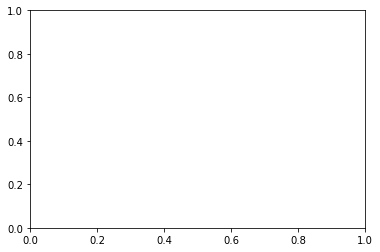

In [44]:
plt.scatter(preds_proba_CB[:,1], preds_proba_XG, alpha=.05)
print(np.corrcoef(preds_proba_XG, preds_proba_CB[:,1]))
print(np.corrcoef(preds_proba_XG, y_val))
print(np.corrcoef(preds_proba_CB[:,1], y_val))
plt.show()
#plt.scatter(y_val, preds_proba_CB[:,1], alpha=.05)
#plt.show()
#plt.scatter(y_val, preds_proba_XG, alpha=.05)
#plt.show()
plt.hist(y_val - preds_proba_CB[:,1], bins=20, alpha=.5, label='CB')
plt.hist(y_val - preds_proba_XG, bins=20, alpha=.5, label='XG')
plt.legend()
plt.grid(True)
plt.show()
plt.scatter((y_val - preds_proba_CB[:,1]), (y_val - preds_proba_XG), alpha=.05)
plt.plot(np.arange(-1,1,.01),np.arange(-1,1,.01),color='red',lw=3)
plt.grid(True)
plt.show()
plt.scatter(np.abs(y_val - preds_proba_CB[:,1]), np.abs(y_val - preds_proba_XG), alpha=.05)
plt.plot(np.arange(0,1,.01),np.arange(0,1,.01),color='red',lw=3)
plt.grid(True)

## Split validation set to learn optimal weights for ensembling

In [25]:
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_val, y_val, test_size=0.20, random_state=42, shuffle=True )

In [65]:
xg_train_2 = xgb.DMatrix(X_train_2.values, label=y_train_2)
xg_test_2 = xgb.DMatrix(X_val_2.values, label=y_val_2)
pred_xg = bst.predict(xg_train_2)
metrics.roc_auc_score(y_train_2, pred_xg)

0.8603399269713169

In [68]:
pred_cb = model.predict_proba(X_train_2)[:,1]
metrics.roc_auc_score(y_train_2, pred_cb)

0.8680680223002212

In [88]:
np.corrcoef(pred_xg, pred_cb)
np.corrcoef(y_train_2, pred_xg)

array([[1.        , 0.56999421],
       [0.56999421, 1.        ]])

In [81]:
pred = np.transpose(np.vstack((pred_xg, pred_cb)))
pred.shape

(20825, 2)

In [ ]:
# Initialize CatBoostClassifier
model_ens = CatBoostClassifier(iterations=100,
                           learning_rate=0.01,
                           depth=6,
                           eval_metric='AUC')

# Fit model
model_ens.fit(pred, y_train_2)

# Get predicted classes
preds_class_ens = model.predict(X_val_2)

In [85]:
preds_proba_ens = model.predict_proba(X_val_2)
metrics.roc_auc_score(y_val_2, preds_proba_ens[:,1])

0.8753685676416134

In [89]:
submission_cb = pd.DataFrame([unlabeled.encounter_id,model.predict_proba(df_pred)[:,1]]).T


(10234, 177)

In [ ]:
submission = pd.DataFrame([unlabeled.encounter_id,model.predict_proba(df_pred)[:,1]]).T
submission.encounter_id = submission.encounter_id.astype('int32')
submission.set_index('encounter_id',inplace=True)
submission.columns = ['diabetes_mellitus']
submission.to_csv('submissions/SolutionWiDS2021_Ens.csv')